In [1]:
%%HTML
<link rel="stylesheet" type="text/css" href="custom.css">

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import fudebako
import importlib

pd.options.display.float_format = '{:.2f}'.format

In [3]:
t0 = fudebako.s_df.index[0]
p1 = fudebako.Portfolio()
p1.add(t0, 5, 0, 'C', 22000)
p1.add(t0, -10, 0, 'C', 22250)
p1.add(t0, 5, 0, 'C', 22500)

# ロングバタフライ再考

### ケーススタディ

下記のようなロングバタフライを組んでみる
* 2018/02/13 15:15
* 2018年3月限先物: 21166.10

In [4]:
cost = (p1.position['qty'] * p1.position['a_price']).sum()
print('コスト:{:.2f}(1セット当り:{:.2f})'.format(cost, cost / len(p1.position)))
display(p1.position[['code', 'qty', 'a_price', 'delta', 'gamma', 'vega', 'theta']])

コスト:101.88(1セット当り:33.96)


,code,qty,a_price,delta,gamma,vega,theta
0,1803C22000,5.00,245.21,1.45,1.23,9241.49,-50.34
1,1803C22250,-10.00,170.31,-2.26,-2.23,-16220.75,85.28
2,1803C22500,5.00,115.79,0.85,0.96,6828.51,-34.99


* 最大利益: 120 * 5 = 600
* 最大損失: 20.2 * 5 = 101

### 実際の損益

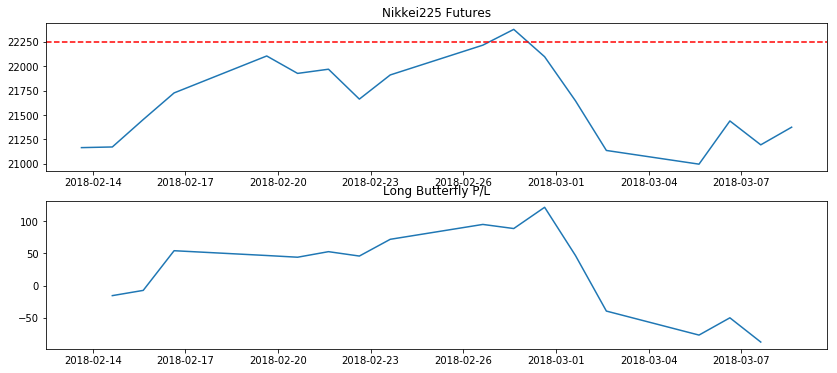

In [5]:
df1 = fudebako.get_portfolio_history(p1, fudebako.s_df.index[1:-1])
df1_pl = df1.groupby("timestamp").sum()["pl"]

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(fudebako.s_df["1803"])
ax1.axhline(22250, linestyle="--", color="r")
ax2.plot(df1_pl)
ax1.set_title("Nikkei225 Futures")
ax2.set_title("Long Butterfly P/L")
plt.show()

### なにか手はないか？
* 先物が最大利益の着地点に到達するものの、そのままSQを迎えるほど甘くはない
* この時点で利食いするのは手堅い手段
* 3つの組み合わせのスプレッドを解消するのは少し大変なので、別な手段を考えてみる

* 2018/02/26 15:15
* 2018年3月限先物: 22214.10
* 先物がこの地点から離れると利益を逃す -> 期先でロングストラドルを組んでみる

In [6]:
t0 = fudebako.s_df.index[0]
p2 = fudebako.Portfolio()
p2.add(t0, 5, 0, 'C', 22000)
p2.add(t0, -10, 0, 'C', 22250)
p2.add(t0, 5, 0, 'C', 22500)
t0 = fudebako.s_df.index[9]
p2.add(t0, 1, 1, 'C', 22250)
p2.add(t0, 1, 1, 'P', 22125)

In [7]:
p2.position[['code', 'qty', 'a_price', 'delta', 'gamma', 'vega', 'theta']]

,code,qty,a_price,delta,gamma,vega,theta
0,1803C22000,5.00,245.21,1.45,1.23,9241.49,-50.34
1,1803C22250,-10.00,170.31,-2.26,-2.23,-16220.75,85.28
2,1803C22500,5.00,115.79,0.85,0.96,6828.51,-34.99
3,1804C22250,1.00,440.77,0.45,0.30,3091.17,-5.81
4,1804P22125,1.00,581.43,-0.51,0.29,3112.40,-5.89


### ロングバタフライ + ロングストラドル(期先)

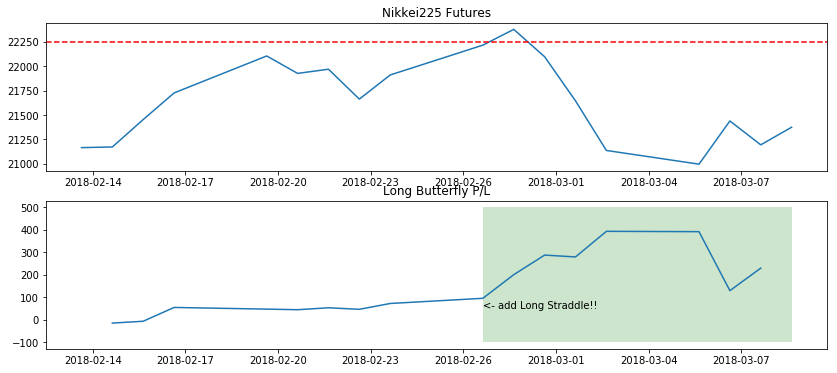

In [8]:
df2 = fudebako.get_portfolio_history(p2, fudebako.s_df.index[10:-1])
df2_pl = df2.groupby("timestamp").sum()["pl"]
df2_pl = df1_pl + df2_pl.reindex(df1_pl.index).fillna(0)

fig = plt.figure(figsize=(14, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)
ax1.plot(fudebako.s_df["1803"])
ax1.axhline(22250, linestyle="--", color="r")
ax2.plot(df2_pl)
change_point = fudebako.s_df.index[9:]
ax2.text(change_point[0], 50, "<- add Long Straddle!!")
yticks = ax2.axes.get_yticks()
ax2.fill_between(change_point, yticks[0], yticks[-1], facecolor="green", alpha=0.2)

ax1.set_title("Nikkei225 Futures")
ax2.set_title("Long Butterfly P/L")
plt.show()

* 追加で組んだロングストラドルの利益が101以上になったら利食いを入れてもよい  
  101 = ロングバタフライのコスト(最大損失)
* 先物でダイナミックヘッジをしてもよさそう
* 最初に組んだロングバタフライはそのまま放置できる